In [1]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt

data = pd.read_csv('https://raw.githubusercontent.com/holoviz/panel/master/examples/assets/occupancy.csv')
data['date'] = data.date.astype('datetime64[ns]')
data = data.set_index('date')

data.tail()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1
2015-02-10 09:33:00,21.10,36.2000,447.0,821.000000,0.005612,1


In [2]:
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas

%matplotlib inline

def mpl_plot(avg, highlight):
    fig = Figure()
    FigureCanvas(fig) # not needed in mpl >= 3.1
    ax = fig.add_subplot()
    avg.plot(ax=ax)
    if len(highlight): highlight.plot(style='o', ax=ax)
    return fig

def find_outliers(variable='Temperature', window=30, sigma=10, view_fn=mpl_plot):
    avg = data[variable].rolling(window=window).mean()
    residual = data[variable] - avg
    std = residual.rolling(window=window).std()
    outliers = (np.abs(residual) > std * sigma)
    return view_fn(avg, avg[outliers])

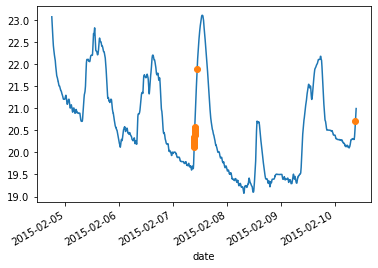

In [3]:
find_outliers(variable='Temperature', window=20, sigma=10)

Column
    [0] Column
        [0] IntSlider(end=90, name='window', start=-30, value=30)
        [1] IntSlider(end=30, name='sigma', start=-10, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00115')
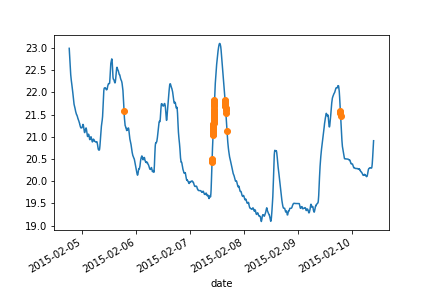

In [5]:
import panel as pn
pn.extension()

pn.interact(find_outliers)

In [6]:
kw = dict(window=(1, 60), variable=sorted(list(data.columns)), sigma=(1, 20))
i = pn.interact(find_outliers, **kw)
i.pprint()

Column
    [0] Column
        [0] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [1] IntSlider(end=60, name='window', start=1, value=30)
        [2] IntSlider(end=20, name='sigma', start=1, value=10)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00128')


Row
    [0] Matplotlib(Figure, name='interactive00128')
    [1] Column
        [0] Markdown(str)
        [1] Select(name='variable', options=['CO2', 'Humidity', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=30)
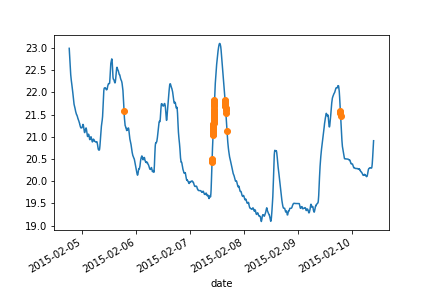

In [7]:
text = "<br>\n# Room Occupancy\nSelect the variable, and the time window for smoothing"

p = pn.Row(i[1][0], pn.Column(text, i[0][0], i[0][1]))
p

In [8]:
i[0][2]

IntSlider(end=20, name='sigma', start=1, value=10)

Row
    [0] ParamFunction(function)
    [1] Column
        [0] Markdown(str)
        [1] RadioButtonGroup(name='variable', options=['Temperature', ...], value='Temperature')
        [2] IntSlider(end=60, name='window', start=1, value=10)
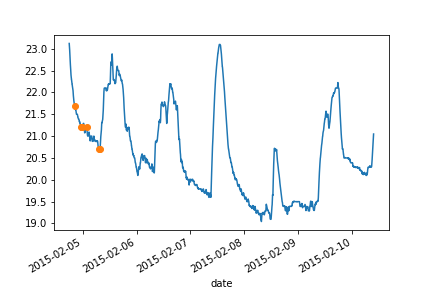

In [9]:
import panel.widgets as pnw

variable  = pnw.RadioButtonGroup(name='variable', value='Temperature', 
                                 options=list(data.columns))
window  = pnw.IntSlider(name='window', value=10, start=1, end=60)

reactive_outliers = pn.bind(find_outliers, variable, window, 10)

widgets   = pn.Column("<br>\n# Room occupancy", variable, window)
occupancy = pn.Row(reactive_outliers, widgets)
occupancy

In [10]:
import param

class RoomOccupancy(param.Parameterized):
    variable  = param.Selector(objects=list(data.columns))
    window    = param.Integer(default=10, bounds=(1, 20))
    sigma     = param.Number(default=10, bounds=(0, 20))

    def view(self):
        return find_outliers(self.variable, self.window, self.sigma)
    
obj = RoomOccupancy()
obj

RoomOccupancy(name='RoomOccupancy00161', sigma=10, variable='Temperature', window=10)

Row
    [0] Column(margin=5, name='RoomOccupancy', width=300)
        [0] StaticText(value='<b>RoomOccupancy</b>')
        [1] Select(name='Variable', options=OrderedDict([('Temperature...]), value='Temperature')
        [2] IntSlider(end=20, name='Window', start=1, value=10)
        [3] FloatSlider(end=20, name='Sigma', value=10)
    [1] ParamMethod(method)
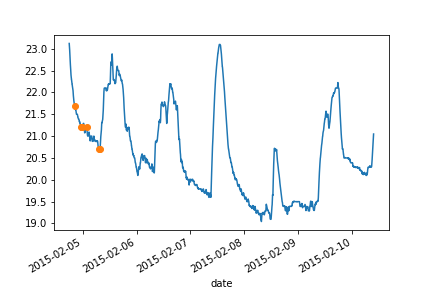

In [11]:
pn.Row(obj.param, obj.view)

In [ ]:
pn.save(